# 2.1. (Mouse) Quality of raw counts

## Input

* `data-create_networks/mouse/mouse_DRG_WT_timecourse_counts.txt`: raw counts generated by featureCounts from the mouse dataset.

## Output

* Figures
    * distribution of prior counts from each sample
    * MA-plots between successive samples
    * PCA plots of samples

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition as decomp

In [2]:
sns.set(style="whitegrid", context="talk", rc={"figure.figsize": (8,5)})

In [3]:
count_file = '../../../data-create_networks/mouse/mouse_DRG_WT_timecourse_counts.txt'

## Import data

In [4]:
raw_counts = pd.read_csv( count_file, sep='\t', header=1, index_col=0 ).iloc[:,5:]

# change column names
raw_counts.columns = [ 'Day' + sample.split('Aligned')[0].split('WT_')[1]
                       for sample in raw_counts.columns ]

# filter
raw_counts = round( raw_counts, 0 )
raw_counts = raw_counts[ (raw_counts.sum(axis=1) > 1) ]

# compute priorcounts
priorcounts = raw_counts.apply( lambda x: np.log2(x+1) )

## Distribution of prior counts

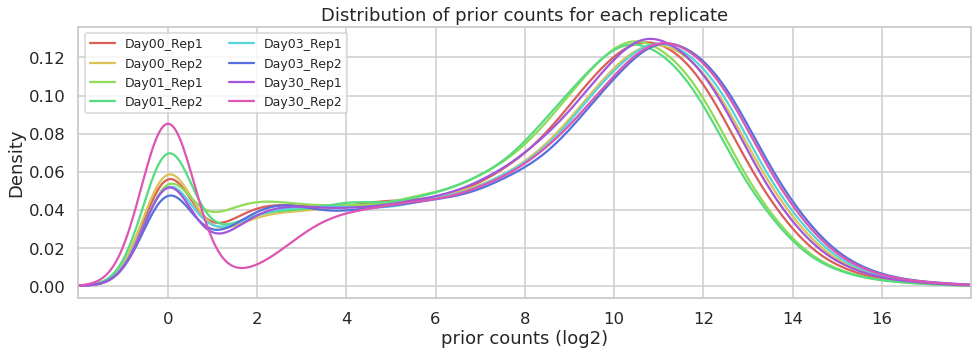

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 5))

colors = sns.color_palette("hls", 8).as_hex()

priorcounts.plot.kde( ax=ax, color=colors )
ax.legend(fontsize='x-small', ncol=2)

ax.set_xlabel("prior counts (log2)")
ax.set_xlim([-2, 18])
ax.set_xticks(range(0,18,2))

plt.title('Distribution of prior counts for each replicate')

plt.show()

## MA-plots between samples
* X-axis: A = average of priorcounts for both samples.
* Y-axis: M = difference of priorcounts between the two samples.

In [6]:
def compute_MA( x, y ):
    M = x - y
    A = (x + y) / 2
    return pd.DataFrame( { "A": A, "M": M } )

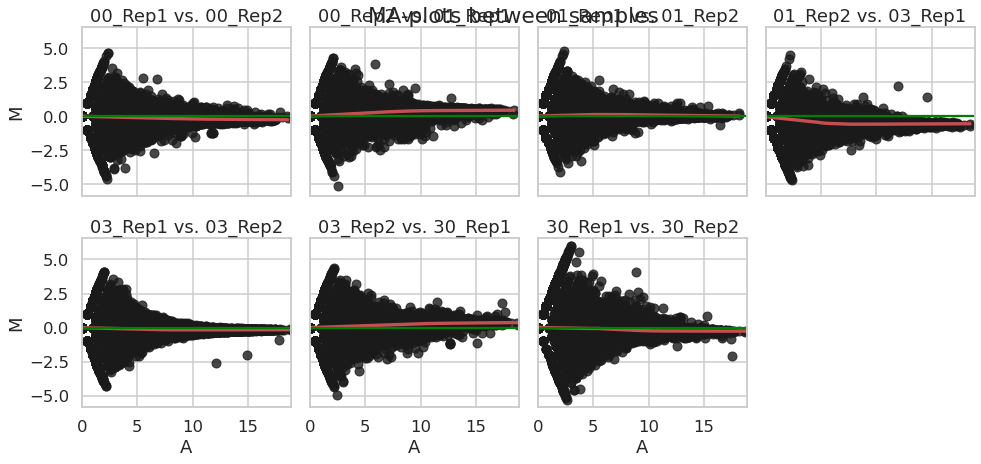

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 7), sharex=True, sharey=True)
plt.subplots_adjust(wspace=.09, hspace=.25)
fig.suptitle('MA-plots between samples', x=.5, y=.92)

cols = priorcounts.columns
for a, ax in enumerate( axes.flatten() ):
    if a < 7:
        i, j = a, a+1
        MA = compute_MA( priorcounts[ cols[i] ], priorcounts[ cols[j] ] )
        sns.regplot( x="A", y="M", data=MA, ax=ax, lowess=True, line_kws={'color':'r'}, color="k" )
        ax.axhline( 0 , color='green' ) # ideal value
        ax.set_title( f'{cols[i][3:]} vs. {cols[j][3:]}' )
        ax.set_xlabel('A' if a > 3 else '')
        ax.set_ylabel('M' if a%4 == 0 else '')
    else: ax.axis('off')

## PCA plot

In [8]:
# decomposition into two components
pca = decomp.PCA(n_components=2)
principalComponents = pca.fit_transform( priorcounts.T.values )
principalDf = pd.DataFrame(principalComponents, columns = ['PC1', 'PC2'], index=priorcounts.columns).T
explained_var = pca.explained_variance_ratio_ # variance for each principal components

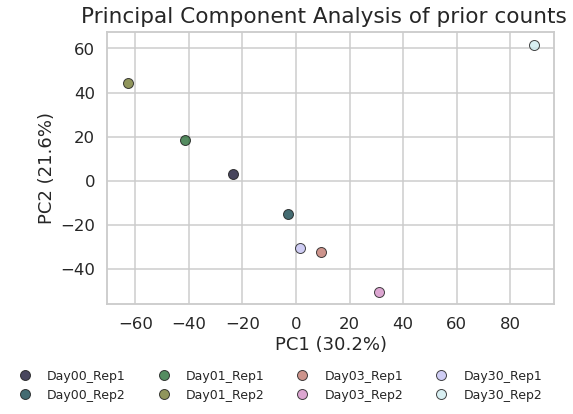

In [9]:
# display
fig, ax = plt.subplots(1, 1)
fig.suptitle('Principal Component Analysis of prior counts', x=.5, y=.95)

colors = sns.color_palette("cubehelix", 8).as_hex()

plots, names = [], []
for i, c in enumerate(principalDf):
    plots += ax.plot( principalDf[c]["PC1"], principalDf[c]["PC2"], "o", label=c,
             color=colors[i], alpha=0.8, ms=10, markeredgecolor="k", mew=1 )
    names.append(c)

#names = [ ' '.join(n.split('_')[:3]) for n in names ]
ax.legend( plots, names, frameon=False,
           loc='upper right', bbox_to_anchor=(1, -0.2),
           markerscale=1, fontsize='x-small', ncol=4
         ).get_frame().set_facecolor('white')

ax.set_xlabel( 'PC1 ({}%)'.format( str(round(explained_var[0]*100, 1)) ) )
ax.set_ylabel( 'PC2 ({}%)'.format( str(round(explained_var[1]*100, 1)) ) )

plt.show()